(362, 544, 3)


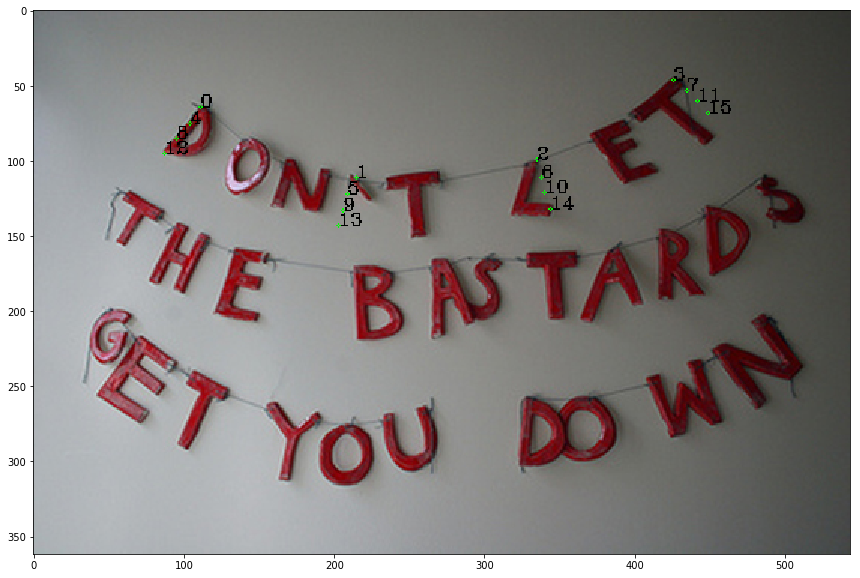

In [98]:
# https://lccurious.github.io/2019/01/29/Thin-Plate-Spline/
# https://blog.csdn.net/VictoriaW/article/details/70161180
%matplotlib inline

import json
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np

img_path = '/Users/cwq/code/notes/computer_version/thin_plate_spline/example.jpg'
gt_path = '/Users/cwq/code/notes/computer_version/thin_plate_spline/example.json'

img = cv2.imread(img_path)
with open(gt_path, 'r', encoding='utf-8') as f:
    data = json.load(f)
print(img.shape)
source_control_points = []
for it in data['shapes']:
    source_control_points.append(np.array(it['points']))
source_control_points = np.array(source_control_points)[0]  

# cv2.drawContours(img, source_control_points, -1, color=(255,0,0))
viz_img = img.copy()
for i, pnt in enumerate(source_control_points):
    viz_img = cv2.circle(viz_img, tuple(pnt), 1, color=(0,255,0))
    viz_img = cv2.putText(viz_img, f"{i}", (pnt[0], pnt[1]), cv2.FONT_HERSHEY_COMPLEX, 0.4, (0,0,0))

plt.figure(figsize=(20,10))
plt.imshow(viz_img[:,:,::-1])
plt.show()

target_control_points.shape torch.Size([16, 2])
source_control_points.shape (16, 2)


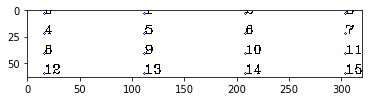

In [135]:
# 生成 (-1, -1) 范围点的目标控制点
target_height = 64
target_width = 320

r1 = r2 = 0.9
grid_height = grid_width = 4

target_control_points = torch.Tensor(list(itertools.product(
    np.arange(-r1, r1 + 0.00001, 2.0  * r1 / (grid_height - 1)),
    np.arange(-r2, r2 + 0.00001, 2.0  * r2 / (grid_width - 1)),
)))
Y, X = target_control_points.split(1, dim = 1)
target_control_points = torch.cat([X, Y], dim = 1)
print('target_control_points.shape', target_control_points.shape)
print('source_control_points.shape', source_control_points.shape)

# 显示目标控制点
target_img_demo = np.ones((target_height, target_width, 3), dtype=np.uint8)*255
target_control_points_abs = []
for i,it in enumerate(target_control_points):
    _x = (it[0]/2 + 0.5)*target_width
    _y = (it[1]/2 + 0.5)*target_height
    target_control_points_abs.append((_x.item(), _y.item()))
    cv2.circle(target_img_demo, (_x, _y), 1, color=(0,0,255))
    cv2.putText(target_img_demo, f"{i}", (_x, _y), cv2.FONT_HERSHEY_COMPLEX, 0.4, (0,0,0))
plt.imshow(target_img_demo)
plt.show()

In [103]:
import torch
import itertools
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function, Variable

# phi(x1, x2) = r^2 * log(r), where r = ||x1 - x2||_2
def compute_partial_repr(input_points, control_points):
    N = input_points.size(0)
    M = control_points.size(0)
    pairwise_diff = input_points.view(N, 1, 2) - control_points.view(1, M, 2)
    # original implementation, very slow
    # pairwise_dist = torch.sum(pairwise_diff ** 2, dim = 2) # square of distance
    pairwise_diff_square = pairwise_diff * pairwise_diff
    pairwise_dist = pairwise_diff_square[:, :, 0] + pairwise_diff_square[:, :, 1]
    repr_matrix = 0.5 * pairwise_dist * torch.log(pairwise_dist)
    # fix numerical error for 0 * log(0), substitute all nan with 0
    mask = repr_matrix != repr_matrix
    repr_matrix.masked_fill_(mask, 0)
    return repr_matrix

def grid_sample(input, grid, canvas = None):
    output = F.grid_sample(input, grid)
    if canvas is None:
        return output
    else:
        input_mask = input.data.new(input.size()).fill_(1)
        output_mask = F.grid_sample(input_mask, grid)
        padded_output = output * output_mask + canvas * (1 - output_mask)
        return padded_output

class TPSGridGen(nn.Module):
    def __init__(self, target_height, target_width, target_control_points):
        super(TPSGridGen, self).__init__()
        assert target_control_points.ndimension() == 2
        assert target_control_points.size(1) == 2
        N = target_control_points.size(0)
        self.num_points = N
        target_control_points = target_control_points.float()

        # create padded kernel matrix
        forward_kernel = torch.zeros(N + 3, N + 3)
        target_control_partial_repr = compute_partial_repr(target_control_points, target_control_points)
        forward_kernel[:N, :N].copy_(target_control_partial_repr)
        forward_kernel[:N, -3].fill_(1)
        forward_kernel[-3, :N].fill_(1)
        forward_kernel[:N, -2:].copy_(target_control_points)
        forward_kernel[-2:, :N].copy_(target_control_points.transpose(0, 1))
        # compute inverse matrix
        inverse_kernel = torch.inverse(forward_kernel)

        # create target cordinate matrix
        HW = target_height * target_width
        target_coordinate = list(itertools.product(range(target_height), range(target_width)))
        target_coordinate = torch.Tensor(target_coordinate) # HW x 2
        Y, X = target_coordinate.split(1, dim = 1)
        Y = Y * 2 / (target_height - 1) - 1
        X = X * 2 / (target_width - 1) - 1
        target_coordinate = torch.cat([X, Y], dim = 1) # convert from (y, x) to (x, y)
        target_coordinate_partial_repr = compute_partial_repr(target_coordinate, target_control_points)
        target_coordinate_repr = torch.cat([
            target_coordinate_partial_repr, torch.ones(HW, 1), target_coordinate
        ], dim = 1)

        # register precomputed matrices
        self.register_buffer('inverse_kernel', inverse_kernel)
        self.register_buffer('padding_matrix', torch.zeros(3, 2))
        self.register_buffer('target_coordinate_repr', target_coordinate_repr)

    def forward(self, source_control_points):
        assert source_control_points.ndimension() == 3
        assert source_control_points.size(1) == self.num_points
        assert source_control_points.size(2) == 2
        batch_size = source_control_points.size(0)

        Y = torch.cat([source_control_points, Variable(self.padding_matrix.expand(batch_size, 3, 2))], 1)
        mapping_matrix = torch.matmul(Variable(self.inverse_kernel), Y)
        source_coordinate = torch.matmul(Variable(self.target_coordinate_repr), mapping_matrix)
        return source_coordinate

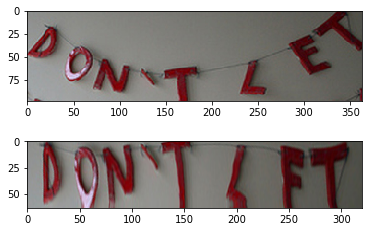

In [123]:
# 归一化 source_control_points
img_height, img_width = img.shape[:2]

source_control_points2 = source_control_points.astype(np.float)
source_control_points2[:,0] = (source_control_points2[:,0] / img_width - 0.5) * 2
source_control_points2[:,1] = (source_control_points2[:,1] / img_height - 0.5) * 2

tps_grid_gen = TPSGridGen(target_height, target_width, target_control_points)
source_coordinate = tps_grid_gen(torch.tensor([source_control_points2], dtype=torch.float))
grid = source_coordinate.view(1, target_height, target_width, 2)

source_img = torch.tensor([cv2.cvtColor(img, cv2.COLOR_BGR2RGB).transpose(2,0,1)], dtype=torch.float)
canvas = Variable(torch.Tensor(1, 3, target_height, target_width).fill_(255))
transformed_x = grid_sample(source_img, grid, canvas)

# img = transformed_x[0].numpy().transpose(1,2,0).astype(np.uint8)

rect = cv2.boundingRect(source_control_points)
origin_img = img[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]][:,:,::-1]

fig=plt.figure()
columns = 1
rows = 2
fig.add_subplot(rows, columns, 1)
plt.imshow(origin_img)
fig.add_subplot(rows, columns, 2)
plt.imshow(transformed_x[0].numpy().transpose(1,2,0).astype(np.uint8))
plt.show()

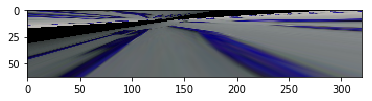

In [138]:
# 投影变换结果
H, _ = cv2.findHomography(srcPoints=source_control_points, dstPoints=np.array(target_control_points_abs))
pers_img = cv2.warpPerspective(img, H, (target_width, target_height))
plt.imshow(pers_img)
plt.show()